In [2]:
# Load Libraries
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2, ToTensor

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# torchvision.models.detection.maskrcnn_resnet50_fpn

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import torchvision.models.resnet as resnet

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
# Loading Train and Validation Dataset
train_df = pd.read_csv('/kaggle/input/wheat-datasets/Dataset/train.csv')
train_df.shape

train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(float)
train_df['y'] = train_df['y'].astype(float)
train_df['w'] = train_df['w'].astype(float)
train_df['h'] = train_df['h'].astype(float)

image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-1:]
train_ids = image_ids #[:-665]

valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

In [5]:
# Creation of Test Dataset
from sklearn.utils import shuffle
import random
class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()
        self.df = dataframe
        self.image_ids = dataframe['image_id'].unique()
        self.image_ids = shuffle(self.image_ids)
        self.labels = [np.zeros((0, 5), dtype=np.float32)] * len(self.image_ids)
        self.img_size = 1024
        self.im_w, self.im_h = self.img_size, self.img_size
        
        for i, img_id in enumerate(self.image_ids):
            records = self.df[self.df['image_id'] == img_id]
            boxes = records[['x', 'y', 'w', 'h']].values
            boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
            boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
            boxesyolo = []
            for box in boxes:
                x1, y1, x2, y2 = box
                xc, yc, w, h = 0.5*x1/self.im_w+0.5*x2/self.im_w, 0.5*y1/self.im_h+0.5*y2/self.im_h, abs(x2/self.im_w-x1/self.im_w), abs(y2/self.im_h-y1/self.im_h)
                boxesyolo.append([0, xc, yc, w, h])
            self.labels[i] = np.array(boxesyolo)
        
        self.image_dir = image_dir
        self.transforms = transforms
        
        self.mosaic = False
        self.augment = True

    def __getitem__(self, index: int):
        self.mosaic = random.randint(0,1) == 0
        if self.mosaic:
            img, labels = load_mosaic(self, index)
            shapes = None
        else:
            img, (h0, w0), (h, w) = load_image(self, index)
            shape = self.img_size
            img, ratio, pad = letterbox(img, shape, auto=False, scaleup=self.augment)
            shapes = (h0, w0), ((h / h0, w / w0), pad)
            labels = []
            x = self.labels[index]
            if x.size > 0:
                labels = x.copy()
                labels[:, 1] = ratio[0] * w * (x[:, 1] - x[:, 3] / 2) + pad[0]
                labels[:, 2] = ratio[1] * h * (x[:, 2] - x[:, 4] / 2) + pad[1]
                labels[:, 3] = ratio[0] * w * (x[:, 1] + x[:, 3] / 2) + pad[0]
                labels[:, 4] = ratio[1] * h * (x[:, 2] + x[:, 4] / 2) + pad[1]
        
        if self.augment:
            if not self.mosaic:
                img, labels = random_affine(img, labels, degrees=0, translate=0, scale=0, shear=0)
            augment_hsv(img, hgain=0.0138, sgain= 0.678, vgain=0.36)
            
        return img, labels

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [6]:
# Data Augmentation definitions
def load_image(self, index):
    # loads 1 image from dataset, returns img, original hw, resized hw
    image_id = self.image_ids[index]
    imgpath = '/kaggle/input/wheat-datasets/Dataset/train'
    img = cv2.imread(f'{imgpath}/{image_id}.jpg', cv2.IMREAD_COLOR)
    
    assert img is not None, 'Image Not Found ' + imgpath
    h0, w0 = img.shape[:2]  # orig hw
    return img, (h0, w0), img.shape[:2]

def load_mosaic(self, index):
    # loads images in a mosaic
    labels4 = []
    s = self.img_size
    xc, yc = [int(random.uniform(s * 0.5, s * 1.5)) for _ in range(2)]  # mosaic center x, y
    indices = [index] + [random.randint(0, len(self.labels) - 1) for _ in range(3)]  # 3 additional image indices
    for i, index in enumerate(indices):
        # Load image
        img, _, (h, w) = load_image(self, index)

        # place img in img4
        if i == 0:  # top left
            img4 = np.full((s * 2, s * 2, img.shape[2]), 114, dtype=np.uint8)  # base image with 4 tiles
            x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
            x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
        elif i == 1:  # top right
            x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
            x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
        elif i == 2:  # bottom left
            x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
            x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
        elif i == 3:  # bottom right
            x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
            x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)

        img4[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]
        padw = x1a - x1b
        padh = y1a - y1b

        # Labels
        x = self.labels[index]
        labels = x.copy()
        if x.size > 0:  # Normalized xywh to pixel xyxy format
            labels[:, 1] = w * (x[:, 1] - x[:, 3] / 2) + padw
            labels[:, 2] = h * (x[:, 2] - x[:, 4] / 2) + padh
            labels[:, 3] = w * (x[:, 1] + x[:, 3] / 2) + padw
            labels[:, 4] = h * (x[:, 2] + x[:, 4] / 2) + padh
        labels4.append(labels)

    # Concat/clip labels
    if len(labels4):
        labels4 = np.concatenate(labels4, 0)
        # np.clip(labels4[:, 1:] - s / 2, 0, s, out=labels4[:, 1:])  # use with center crop
        np.clip(labels4[:, 1:], 0, 2 * s, out=labels4[:, 1:])  # use with random_affine

    # Augment
    # img4 = img4[s // 2: int(s * 1.5), s // 2:int(s * 1.5)]  # center crop (WARNING, requires box pruning)
    img4, labels4 = random_affine(img4, labels4,
                                  degrees=1.98 * 2,
                                  translate=0.05 * 2,
                                  scale=0.05 * 2,
                                  shear=0.641 * 2,
                                  border=-s // 2)  # border to remove

    return img4, labels4

def random_affine(img, targets=(), degrees=10, translate=.1, scale=.1, shear=10, border=0):
    # torchvision.transforms.RandomAffine(degrees=(-10, 10), translate=(.1, .1), scale=(.9, 1.1), shear=(-10, 10))
    # https://medium.com/uruvideo/dataset-augmentation-with-random-homographies-a8f4b44830d4

    if targets is None:  # targets = [cls, xyxy]
        targets = []
    height = img.shape[0] + border * 2
    width = img.shape[1] + border * 2

    # Rotation and Scale
    R = np.eye(3)
    a = random.uniform(-degrees, degrees)
    # a += random.choice([-180, -90, 0, 90])  # add 90deg rotations to small rotations
    s = random.uniform(1 - scale, 1 + scale)
    R[:2] = cv2.getRotationMatrix2D(angle=a, center=(img.shape[1] / 2, img.shape[0] / 2), scale=s)

    # Translation
    T = np.eye(3)
    T[0, 2] = random.uniform(-translate, translate) * img.shape[0] + border  # x translation (pixels)
    T[1, 2] = random.uniform(-translate, translate) * img.shape[1] + border  # y translation (pixels)

    # Shear
    S = np.eye(3)
    S[0, 1] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # x shear (deg)
    S[1, 0] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # y shear (deg)

    # Combined rotation matrix
    M = S @ T @ R  # ORDER IS IMPORTANT HERE!!
    if (border != 0) or (M != np.eye(3)).any():  # image changed
        img = cv2.warpAffine(img, M[:2], dsize=(width, height), flags=cv2.INTER_LINEAR, borderValue=(114, 114, 114))

    # Transform label coordinates
    n = len(targets)
    if n:
        # warp points
        xy = np.ones((n * 4, 3))
        xy[:, :2] = targets[:, [1, 2, 3, 4, 1, 4, 3, 2]].reshape(n * 4, 2)  # x1y1, x2y2, x1y2, x2y1
        xy = (xy @ M.T)[:, :2].reshape(n, 8)

        # create new boxes
        x = xy[:, [0, 2, 4, 6]]
        y = xy[:, [1, 3, 5, 7]]
        xy = np.concatenate((x.min(1), y.min(1), x.max(1), y.max(1))).reshape(4, n).T

        # reject warped points outside of image
        xy[:, [0, 2]] = xy[:, [0, 2]].clip(0, width)
        xy[:, [1, 3]] = xy[:, [1, 3]].clip(0, height)
        w = xy[:, 2] - xy[:, 0]
        h = xy[:, 3] - xy[:, 1]
        area = w * h
        area0 = (targets[:, 3] - targets[:, 1]) * (targets[:, 4] - targets[:, 2])
        ar = np.maximum(w / (h + 1e-16), h / (w + 1e-16))  # aspect ratio
        i = (w > 4) & (h > 4) & (area / (area0 * s + 1e-16) > 0.2) & (ar < 10)

        targets = targets[i]
        targets[:, 1:5] = xy[i]

    return img, targets

def augment_hsv(img, hgain=0.5, sgain=0.5, vgain=0.5):
    r = np.random.uniform(-1, 1, 3) * [hgain, sgain, vgain] + 1  # random gains
    hue, sat, val = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2HSV))
    dtype = img.dtype  # uint8

    x = np.arange(0, 256, dtype=np.int16)
    lut_hue = ((x * r[0]) % 180).astype(dtype)
    lut_sat = np.clip(x * r[1], 0, 255).astype(dtype)
    lut_val = np.clip(x * r[2], 0, 255).astype(dtype)

    img_hsv = cv2.merge((cv2.LUT(hue, lut_hue), cv2.LUT(sat, lut_sat), cv2.LUT(val, lut_val))).astype(dtype)
    cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR, dst=img)  # no return needed

def letterbox(img, new_shape=(416, 416), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
    # Resize image to a 32-pixel-multiple rectangle https://github.com/ultralytics/yolov3/issues/232
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, 64), np.mod(dh, 64)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = new_shape
        ratio = new_shape[0] / shape[1], new_shape[1] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)

In [8]:
import random, math
# Albumentations
def get_train_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})



def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})



def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = WheatDataset(train_df, "/kaggle/input/wheat-datasets/Dataset/train", get_train_transform())
valid_dataset = WheatDataset(valid_df, "/kaggle/input/wheat-datasets/Dataset/train", get_valid_transform())

#train_dataset = WheatDataset(train_df, DIR_TRAIN, get_augumentation(phase='train'))

# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


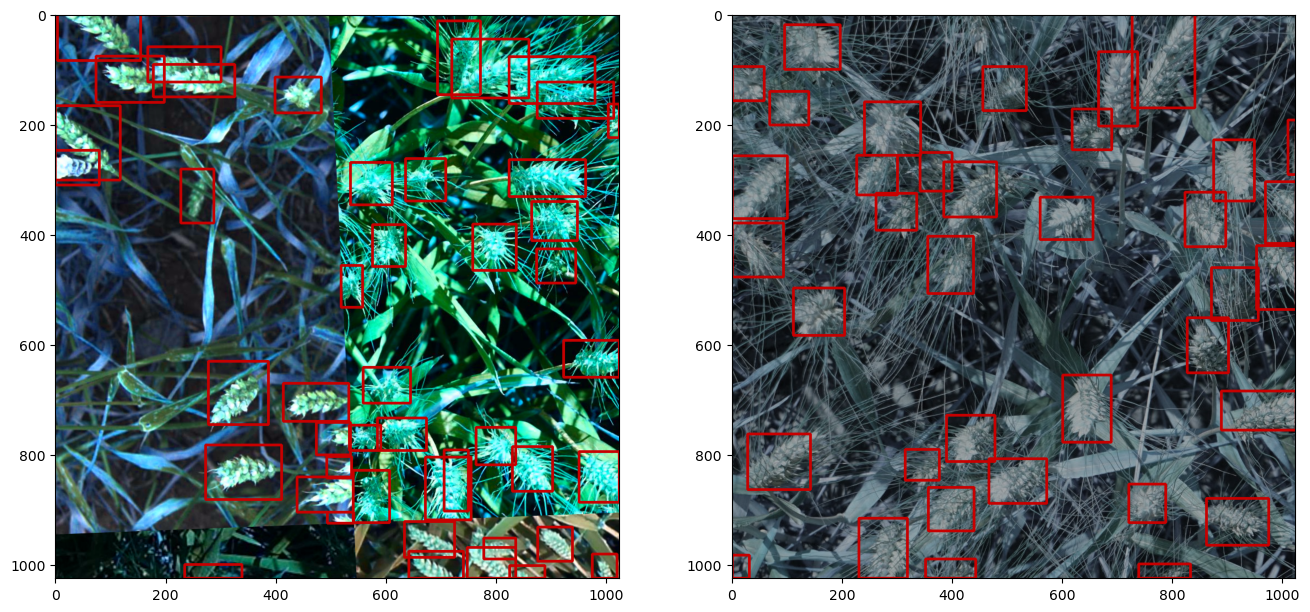

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
images, targets = next(iter(train_data_loader))
for i in range(2):  
    boxes = targets[i]
    sample = images[i]

    for box in boxes:
        cv2.rectangle(sample,
                  (int(box[1]), int(box[2])),
                  (int(box[3]), int(box[4])),
                  (200, 0, 0), 3)

    ax[i].imshow(sample)
plt.show()

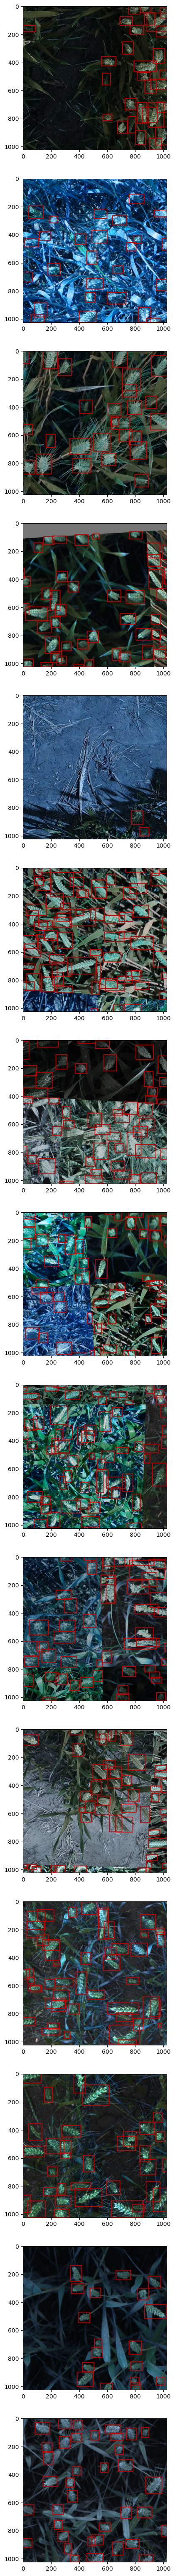

In [8]:
# Some example images
fig, ax = plt.subplots(15, 1, figsize=(160, 80))
images, targets = next(iter(train_data_loader))
for i in range(15):  
    boxes = targets[i]
    sample = images[i]

    for box in boxes:
        cv2.rectangle(sample,
                  (int(box[1]), int(box[2])),
                  (int(box[3]), int(box[4])),
                  (200, 0, 0), 3)

    ax[i].imshow(sample)
plt.show()

In [9]:
test_df = pd.read_csv('/kaggle/input/wheat-datasets/Dataset/sample_submission.csv')

In [10]:
class WheatTestDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [11]:
# Albumentations
def get_test_transform():
    return A.Compose([
        # A.Resize(512, 512),
        ToTensorV2(p=1.0)
    ])

In [12]:
test_dataset = WheatTestDataset(test_df, "/kaggle/input/wheat-datasets/Dataset/test", get_test_transform())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

In [13]:
WEIGHTS_FILE = '/kaggle/input/weights-fastrcnn/fasterrcnn_resnet50_fpn_best.pth'
mrcnn_WEIGHTS_FILE = '/kaggle/input/mask-weights/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth'
test_df = pd.read_csv('/kaggle/input/wheat-datasets/Dataset/sample_submission.csv')

In [14]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the trained weights
model.load_state_dict(torch.load(WEIGHTS_FILE))
model.eval()

x = model.to(device)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Argu

In [15]:
# # Load the pre-trained Mask R-CNN model
# model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

# # Define the number of classes (including the background)
# num_classes = 2

# # Get the number of input features for the box predictor
# in_features = model.roi_heads.box_predictor.cls_score.in_features

# # Replace the pre-trained box predictor with a new one
# model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# # Get the number of input features for the mask predictor
# in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

# # Replace the pre-trained mask predictor with a new one
# hidden_layer = 256
# model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(in_features_mask,
#                                                                                             hidden_layer,
#                                                                                             num_classes)
# # Set the model to evaluation mode
# model.load_state_dict(torch.load(mrcnn_WEIGHTS_FILE))
# model.eval()

# # Move the model to GPU (if available)
# x = model.to(device)

# # Load the pre-trained Mask R-CNN model
# model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

# # Define the number of classes (including the background)
# num_classes = 2

# # Get the number of input features for the box predictor
# in_features = model.roi_heads.box_predictor.cls_score.in_features

# # Replace the pre-trained box predictor with a new one
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# # Check if the model has the mask_predictor attribute
# if hasattr(model.roi_heads, 'mask_predictor'):
#     # Get the number of input features for the mask predictor
#     in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

#     # Replace the pre-trained mask predictor with a new one
#     hidden_layer = 256
#     model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(in_features_mask,
#                                                                                                 hidden_layer,
#                                                                                                 num_classes)

# # Load the trained weights
# state_dict = torch.load(mrcnn_WEIGHTS_FILE)
# if 'model' in state_dict.keys():
#     state_dict = state_dict['model']
# for k in list(state_dict.keys()):
#     if 'box_predictor' in k:
#         if state_dict[k].shape != model.roi_heads.box_predictor.cls_score.weight.shape:
#             del state_dict[k]
#     elif 'mask_predictor' in k:
#         if hasattr(model.roi_heads, 'mask_predictor') and state_dict[k].shape != model.roi_heads.mask_predictor.mask_fcn_logits.weight.shape:
#             del state_dict[k]
# model.load_state_dict(state_dict, strict=False)

# # Set the model to evaluation mode
# model.eval()

# # Move the model to GPU (if available)
# x = model.to(device)

In [16]:
def collate_fn(batch):
    return tuple(zip(*batch))

test_dataset = WheatTestDataset(test_df, '/kaggle/input/wheat-datasets/Dataset/test', get_test_transform())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

In [17]:
detection_threshold = 0.85
results = []

for images, image_ids in test_data_loader:

    images = list(image.to(device) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }

        
        results.append(result)

In [18]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()

image_id                                   PredictionString
0  aac893a91  0.9978 554 531 128 192 0.9947 616 920 77 103 0...
1  51f1be19e  0.9973 607 93 162 177 0.9950 843 268 133 201 0...
2  f5a1f0358  0.9958 540 276 110 114 0.9952 939 435 84 185 0...
3  796707dd7  0.9927 940 75 84 100 0.9922 895 333 113 92 0.9...
4  51b3e36ab  0.9988 836 456 187 146 0.9981 544 34 246 130 0...

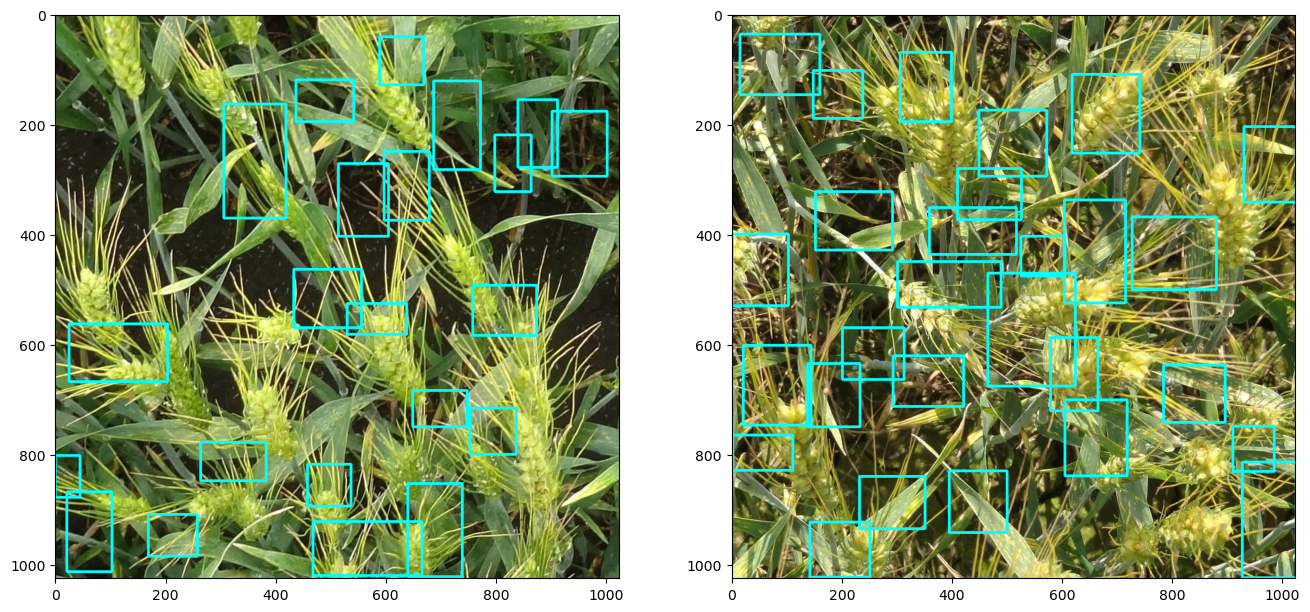

In [21]:
# sample = images[1].permute(1,2,0).cpu().numpy()
# boxes = outputs[1]['boxes'].data.cpu().numpy()
# scores = outputs[1]['scores'].data.cpu().numpy()

# boxes = boxes[scores >= detection_threshold].astype(np.int32)

# fig, ax = plt.subplots(1, 1, figsize=(16, 8))

# for box in boxes:
#     cv2.rectangle(sample,
#                   (box[0], box[1]),
#                   (box[2], box[3]),
#                   (0, 150, 100), 3)
    
# ax.set_axis_off()
# ax.imshow(sample)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs = axs.ravel()
for i in range(2):
    sample = images[i].permute(1, 2, 0).cpu().numpy()
    boxes = outputs[i]['boxes'].data.cpu().numpy()
    scores = outputs[i]['scores'].data.cpu().numpy()

    boxes = boxes[scores >= detection_threshold].astype(np.int32)

    for box in boxes:
        cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (0, 150, 100), 3)

    axs[i].imshow(sample)
    
plt.show()

In [ ]:
# #Building a RESNET152 model
# class ResNet152(nn.Module):
#     def __init__(self, num_classes=1000):
#         super(ResNet152, self).__init__()

#         self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.relu = nn.ReLU(inplace=True)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

#         self.layer1 = nn.Sequential(
#             nn.Conv2d(64, 64, kernel_size=1, stride=1, bias=False),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(64, 256, kernel_size=1, stride=1, bias=False),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#         )

#         self.layer2 = nn.Sequential(
#             nn.Conv2d(256, 128, kernel_size=1, stride=2, bias=False),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(128, 512, kernel_size=1, stride=1, bias=False),
#             nn.BatchNorm2d(512),
#             nn.ReLU(inplace=True),
#         )

#         self.layer3 = nn.Sequential(
#             nn.Conv2d(512, 256, kernel_size=1, stride=2, bias=False),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 1024, kernel_size=1, stride=1, bias=False),
#             nn.BatchNorm2d(1024),
#             nn.ReLU(inplace=True),
#         )

#         self.layer4 = nn.Sequential(
#             nn.Conv2d(1024, 512, kernel_size=1, stride=2, bias=False),
#             nn.BatchNorm2d(512),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
#             nn.BatchNorm2d(512),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 2048, kernel_size=1, stride=1, bias=False),
#             nn.BatchNorm2d(2048),
#             nn.ReLU(inplace=True),
#         )

#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(2048, num_classes)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.maxpool(x)

#         x = self.layer1(x) + x
#         x = self.layer2(x) + x
#         x = self.layer3(x) + x
#         x = self.layer4(x) + x

#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)

#         return x

In [ ]:
# #Train the model
# model = ResNet152()
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

# # Train the model for 10 epochs
# for epoch in range(1, 11):
#     print(f"Epoch {epoch}")
#     train_loss, train_acc = 0.0, 0.0
#     val_loss, val_acc = 0.0, 0.0

#     for inputs, targets in train_data_loader:
#         inputs, targets = inputs, targets
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, targets)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item() * inputs.size(0)
#         _, predicted = outputs.max(1)
#         train_acc += predicted.eq(targets).sum().item()
#     train_loss /= len(train_dataset)
#     train_acc /= len(train_dataset)

#     with torch.no_grad():
#         for inputs, targets in valid_data_loader:
#             inputs, targets = inputs, targets
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)
#             val_loss += loss.item() * inputs.size(0)
#             _, predicted = outputs.max(1)
#             val_acc += predicted.eq(targets).sum().item()
#     val_loss /= len(val_dataset)
#     val_acc /= len(val_dataset)

#     print(f"Train loss: {train_loss:.4f} - Train acc: {train_acc:.4f}")
#     print(f"Val loss: {val_loss:.4f} - Val acc: {val_acc:.4f}")